# Day5.2 GPT

### 실습 목표
- GPT 모델을 통해 문장을 생성해보기



## 0. Setting

- 런타임 > 런타임 유형 변경 > GPU



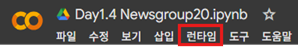

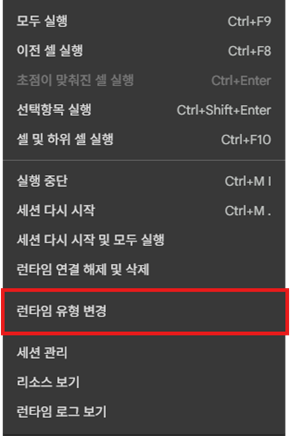

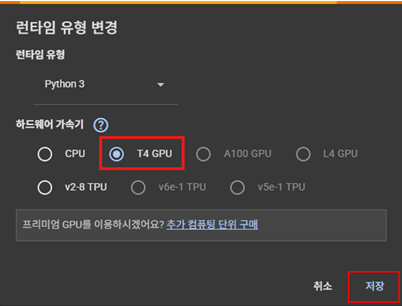

- 필요한 라이브러리 설치 및 호출

In [ ]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, PreTrainedTokenizerFast

- GPU 설정

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


- 시드 고정

    - 동일한 실습 환경에서도 모델의 학습 결과가 일관되도록 랜덤성을 최소화
    - 이를 통해 코드 실행 시 매번 동일한 결과를 재현

In [ ]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

## 1. GPT(Generative Pre-Trained Transformer)의 구조와 동작 과정


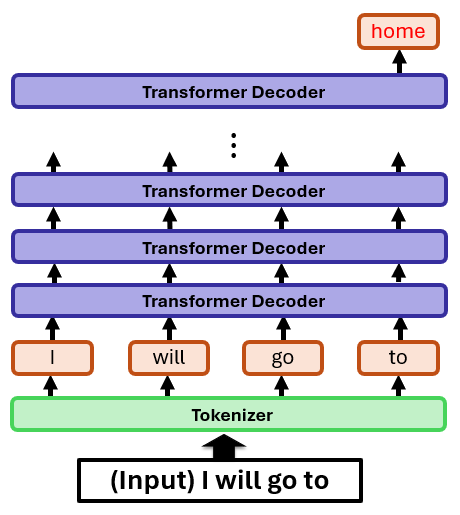

- Generative Pre-Trained Transformer(**GPT**)는 **Transformer의 Decoder**로 이루어진 텍스트 생성 AI 모델

- Input으로 텍스트를 입력 받고, 다음에 올 단어를 예측함
- 동작 과정
  - 1.Input으로 텍스트를 입력 받음
  - 2.Tokenizer를 통해 텍스트를 단어(Token) 단위로 분리
  - 3.각 단어들을 Transformer Decoder를 통과시켜, 최종적으로 마지막 단어 다음에 올 단어를 예측하고 결과로 내보냄
- Tokenizer를 통과해서 분리된 단어들은 Tensor 형태로 바뀜, Transformer Decoder를 통과한 Output 역시 Tensor에서 단어로 바뀜

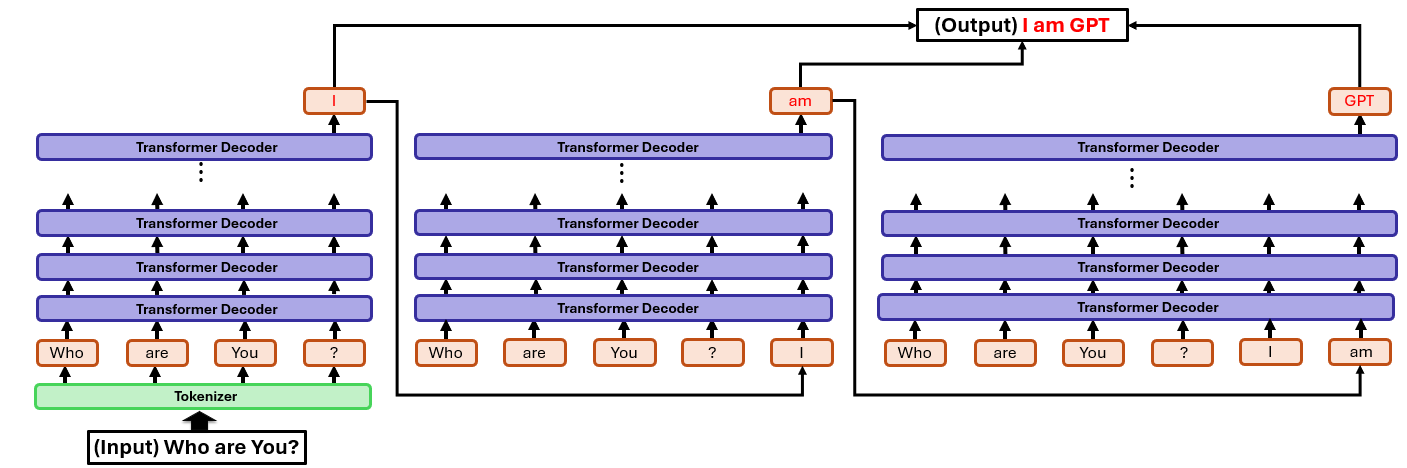


- 이 과정을 **반복**하여 길이가 긴 텍스트(문장 등)를 생성할 수 있음
 - 반복할 때마다 **이전 문장+새로 예측한 단어**를 입력으로 주고 다음 단어를 예측함

## 2. GPT로 문장 생성

#### 2.1 GPT2

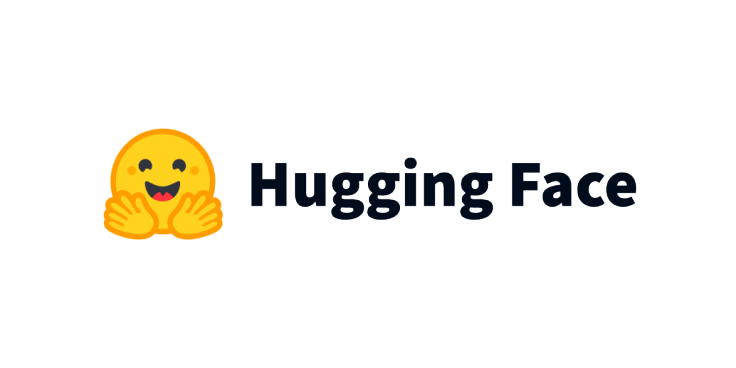

- GPT는 Pre-Trained 되어 저장되어 있으며, **Hugging Face**라는 플랫폼에서 제공하는 `transformers` 라는 라이브러리에서 불러올 수 있음
- 일반적으로 **GPT Tokenizer**와 **GPT 모델**을 각각 불러와서 사용함
- Tokenizer와 모델을 불러오는 코드는 사용하는 모델의 종류에 따라 차이가 있으므로, **암기하기 보다는 필요할 때마다 찾아서 사용**하는 것이 좋음
- 이번 실습에서는 GPT2라는 초기 GPT 모델을 사용
  - `gpt2`는 성능은 좋지 않지만 무료로 사용가능
  - `gpt3.5`, `gpt4`의 경우 유료 API를 구매하면 사용가능
- `transformers.GPT2Tokenizer.from_pretrained("gpt2")` : GPT2 모델에 사용되는 Tokenizer를 불러올 수 있게 해주는 함수
  - `tokenizer.encode(prompt, return_tensors="pt")`
    - 입력 텍스트를 token 단위로 분리하고 Tensor로 변환해줌 **(텍스트 → Tensor(Number))**
  - `tokenizer.decode(output[0],  skip_special_tokens=True)`
    -  GPT 모델이 출력한 output tensor를 다시 텍스트로 변환해줌 **(Tensor(Number) → 텍스트)**
    - `skip_special_tokens=True` : 특수 문자는 무시하고 변환해줌
- `transformers.GPT2LMHeadModel.from_pretrained("gpt2")` : Transformer Decoder로 이루어진 GPT2 모델을 불러올 수 있게 해주는 함수


In [ ]:
# 1. 모델과 Tokenizer 불러오기
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name) # GPT Tokenizer 불러오기
model = GPT2LMHeadModel.from_pretrained(model_name) # GPT 모델 불러오기
model.eval() # 모델 사용을 위해 eval 상태로 바꾸어주기

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
# 2. 입력 문장을 넣고, Tokenizer로 token 단위로 분리하고 Tensor로 변환
prompt = "Once upon a time"
input_ids = tokenizer.encode(prompt, return_tensors="pt")  # Once/upon/a/time
print(input_ids)

tensor([[7454, 2402,  257,  640]])


- `model.generate(input_ids,max_length,do_sample)` : 불러온 모델에 tokenizer를 통과한 텍스트를 입력하여 다음에 올 단어나 문장을 생성하는 함수
  - `max_length` : 문장을 생성할 때, 생성할 문장의 최대 길이
  - `do_sample` : 문장을 생성할 때, 랜덤성을 추가하여 보다 다양성이 높은 문장을 생성하도록 해줌

In [ ]:
# 3. 문장 생성
output = model.generate(
    input_ids,
    max_length=50,         # 문장 생성 최대 길이
    do_sample=True,        # 랜덤성 추가
)
print(output)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


tensor([[ 7454,  2402,   257,   640,   262, 11858,   925,   477,   326,  1744,
           329,  2405,    13,   198,   198, 19093,    11,   340,  2331,    11,
           326,   262,   749,  6156, 25059,   547,   257,  1178,   286,   262,
           749, 20109,   290, 20109,    13,   198,   198,   464, 16781,   495,
           272, 24858,   198,   198,   464, 16781,   495,   272, 24858,   547]])


In [ ]:
# 4. Output을 Tensor에서 텍스트로 변환하고 결과를 출력
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print("📝 생성된 문장:")
print(generated_text)

📝 생성된 문장:
Once upon a time the gods made all that possible for themselves.

Thus, it seems, that the most ancient Greeks were a few of the most ignorant and ignorant.

The Epicurean philosophers

The Epicurean philosophers were


#### 2.2 KoGPT2
  - SKT에서 만든 한국어에 특화된 GPT2 모델
  - GPT2와 동일하게, Tokenizer와 Model을 불러오는 함수가 정해져 있음
  - 마찬가지로 성능은 다소 떨어짐

In [ ]:
# 1. 모델과 Tokenizer 불러오기
tokenizer = PreTrainedTokenizerFast.from_pretrained(
    "skt/kogpt2-base-v2",
    bos_token='</s>', eos_token='</s>', unk_token='<unk>', pad_token='<pad>', mask_token='<mask>'
)
model = GPT2LMHeadModel.from_pretrained("skt/kogpt2-base-v2")

tokenizer.json:   0%|          | 0.00/2.83M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


pytorch_model.bin:   0%|          | 0.00/513M [00:00<?, ?B/s]

In [ ]:
# 2. 입력 문장을 넣고, Tokenizer로 token 단위로 분리하고 Tensor로 변환
prompt = "오늘 날씨는"
input_ids = tokenizer.encode(prompt, return_tensors="pt")

In [ ]:
# 3. 문장 생성
output = model.generate(input_ids, max_length=50, do_sample=True)

model.safetensors:   0%|          | 0.00/513M [00:00<?, ?B/s]

In [ ]:
# 4. Output을 Tensor에서 텍스트로 변환하고 결과를 출력
result = tokenizer.decode(output[0], skip_special_tokens=True)

print("📝 생성 결과:", result)

📝 생성 결과: 오늘 날씨는 대체로 맑겠지만 오후에 중부와 경북지역에 빗방울이 떨어지겠습니다.
오후에 경기 북부와 강원 내륙에는 아침까지 한때 약한 비가 조금 오는 곳이 있겠습니다.
한낮 기온은 어제와 비슷합니다.
서울은 16도, 대전 21도,


## 3. 자유롭게 GPT로 실습
- GPT에 초기 입력 문장(생성하고 싶은 문장의 초반부 텍스트) 및 생성될 텍스트의 길이를 자유롭게 입력하고 생성된 문장의 결과를 확인해보기

- GPT2

In [ ]:
# 1. 모델과 Tokenizer 불러오기
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name) # GPT Tokenizer 불러오기
model = GPT2LMHeadModel.from_pretrained(model_name) # GPT 모델 불러오기
model.eval() # 모델 사용을 위해 eval 상태로 바꾸어주기

# 2. 입력 문장을 넣고, Tokenizer로 token 단위로 분리
prompt = input("Write any text you want!\n")
input_ids = tokenizer.encode(prompt, return_tensors="pt")  # Once/upon/a/time

# 3. 문장 생성
output = model.generate(
    input_ids,
    max_length=int(input("Write the length of the text you want to generate!\n")),         # 문장 생성 최대 길이
    do_sample=True,        # 무작위로 생성 (같은 입력이 들어오더라도 매번 다른 결과를 출력)
)

# 4. 출력
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print("📝 생성된 문장:")
print(generated_text)

Write any text you want!
Once upon a time
Write the length of the text you want to generate!
30


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


📝 생성된 문장:
Once upon a time he would get mad at his own father and claim he wanted to kill his mother for killing his wife, but eventually he realizes that


- KoGPT2

In [ ]:
# 1. 모델과 Tokenizer 불러오기
tokenizer = PreTrainedTokenizerFast.from_pretrained(
    "skt/kogpt2-base-v2",
    bos_token='</s>', eos_token='</s>', unk_token='<unk>', pad_token='<pad>', mask_token='<mask>'
)
model = GPT2LMHeadModel.from_pretrained("skt/kogpt2-base-v2")

# 2. 입력 문장을 넣고, Tokenizer로 token 단위로 분리하고 Tensor로 변환
prompt = input("Write any text you want!\n")
input_ids = tokenizer.encode(prompt, return_tensors="pt")

# 3. 문장 생성
output = model.generate(input_ids, max_length=int(input("Write the length of the text you want to generate!\n")), do_sample=True)

# 4. Output을 Tensor에서 텍스트로 변환하고 결과를 출력
result = tokenizer.decode(output[0], skip_special_tokens=True)

print("📝 생성 결과:", result)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


Write any text you want!
오늘 날씨는
Write the length of the text you want to generate!
30
📝 생성 결과: 오늘 날씨는 맑겠고, 아침 최저기온은 서울 18도, 대전 17도, 대구 19도, 부산 19도, 제주 19도 등으로 전날보다 1~2도
